In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 56.3 MB/s 
     |████████████████████████████████| 197 kB 66.3 MB/s 
     |████████████████████████████████| 59 kB 8.3 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '8db4721e5da84b75a1d5c7742f8f1de4')

In [4]:
results = search_images_bing(key, 'car')
ims = results.attrgot('content_url')
len(ims), len(results)

(150, 150)

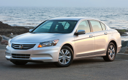

In [5]:
#hide
ims = ['https://st.motortrend.com/uploads/sites/5/2014/10/2012-Honda-Accord-SE-sedan-front-three-quarter.jpg']
dest = '/content/gdrive/MyDrive/fast.ai/auto.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [6]:
car_types = 'car', 'truck', 'pickup_truck'
path = Path('/content/gdrive/MyDrive/fast.ai/Autos')

In [7]:
if not path.exists():
  path.mkdir()
  for o in car_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key, f'{o}')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
dest=(path/'Auto')
dest.mkdir(exist_ok=True)
results=search_images_bing(key, 'car')
download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#444) [Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000004.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000007.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000001.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000010.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000008.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000000.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000009.JPG'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000012.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000013.jpg'),Path('/content/gdrive/MyDrive/fast.ai/Autos/Camion/00000005.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#1) [Path('/content/gdrive/MyDrive/fast.ai/Autos/Auto/00000121.jpg')]

In [11]:
failed.map(Path.unlink)

(#1) [None]

In [12]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [13]:
dls = cars.dataloaders(path)

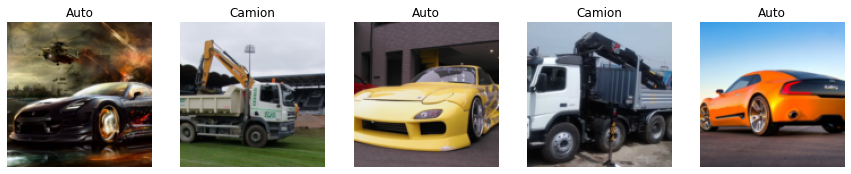

In [14]:
dls.valid.show_batch(max_n=5, nrows=1)

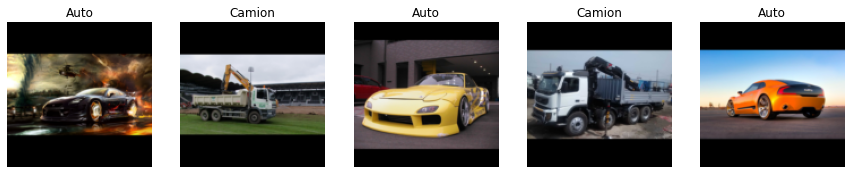

In [15]:
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls=cars.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

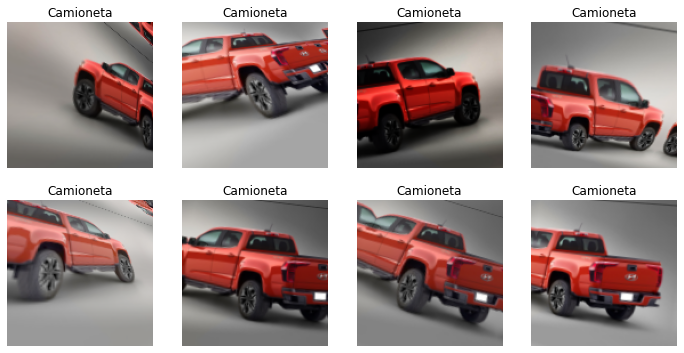

In [16]:
cars = cars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls=cars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
cars=cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls=cars.dataloaders(path)

In [18]:
learn = cnn_learner(dls,resnet18,metrics=error_rate, lr=0.01)
learn.fine_tune(1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

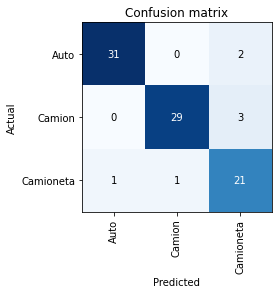

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

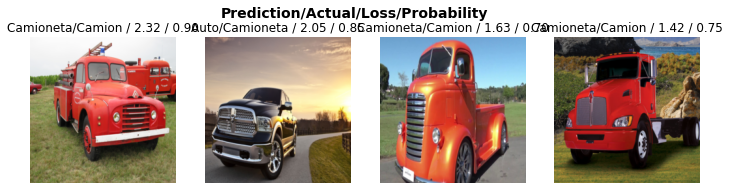

In [20]:
interp.plot_top_losses(4, nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Creando una Aplicacion Online

In [23]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
#path=Path('/content/gdrive/MyDrive/fast.ai')
#path=Path('/content/export.pkl')
learn_inf = load_learner('/content/export.pkl')

In [ ]:
learn_inf.predict(path'/auto.jpg')

In [28]:
learn_inf.dls.vocab

['Auto', 'Camion', 'Camioneta']

# Creando Notebook App

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run = widgets.Button(description='Classify')

In [31]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [32]:
btn_upload = widgets.FileUpload()

In [34]:
VBox([widgets.Label('Select your vehicle!'), 
      btn_upload, btn_run, out_pl, lbl_pred])